In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the shipment data
shipments_df = pd.read_csv(
    "https://raw.githubusercontent.com/flyaflya/persuasive/main/shipments.csv", 
    parse_dates=['plannedShipDate', 'actualShipDate']
)

# Load product line data
product_line_df = pd.read_csv(
    "https://raw.githubusercontent.com/flyaflya/persuasive/main/productLine.csv"
)

# Reduce dataset size for faster processing (4,000 rows instead of 96,805 rows)
shipments_df = shipments_df.head(4000)

print("Shipments data shape:", shipments_df.shape)
print("\nShipments data columns:", shipments_df.columns.tolist())
print("\nFirst few rows of shipments data:")
print(shipments_df.head(10))

print("\n" + "="*50)
print("Product line data shape:", product_line_df.shape)
print("\nProduct line data columns:", product_line_df.columns.tolist())
print("\nFirst few rows of product line data:")
print(product_line_df.head(10))

Shipments data shape: (4000, 5)

Shipments data columns: ['shipID', 'plannedShipDate', 'actualShipDate', 'partID', 'quantity']

First few rows of shipments data:
   shipID plannedShipDate actualShipDate       partID  quantity
0   10001      2013-11-06     2013-10-04  part92b16c5         6
1   10002      2013-10-15     2013-10-04   part66983b         2
2   10003      2013-10-25     2013-10-07  part8e36f25         1
3   10004      2013-10-14     2013-10-08  part30f5de0         1
4   10005      2013-10-14     2013-10-08  part9d64d35         6
5   10006      2013-10-14     2013-10-08  part6cd6167        15
6   10007      2013-10-14     2013-10-08  parta4d5fd1         2
7   10008      2013-10-14     2013-10-08  part08cadf5         1
8   10009      2013-10-14     2013-10-08  part5cc4989        10
9   10010      2013-10-14     2013-10-08  part912ae4c         1

Product line data shape: (11997, 3)

Product line data columns: ['partID', 'productLine', 'prodCategory']

First few rows of product 

Question 1: Data Types and Date Handling - What is the dtype of the actualShipDate series? How can you find out using code? Why is it important that both actualShipDate and plannedShipDate have the same data type for comparison?
Answer: Data Types and Date Handling

In [ ]:
print(shipments_df['actualShipDate'].dtype)

dtype of actualShipDate is datetime64[ns].
It’s important that both actualShipDate and plannedShipDate have the same datetime dtype so that comparisons (>, <) and date subtraction work correctly. 
If one were a string, the comparison would be incorrect or cause errors.

Question 2: String vs Date Comparison - Can you give an example where comparing two dates as strings would yield unintuitive results, e.g. what happens if you try to compare “04-11-2025” and “05-20-2024” as strings vs as dates?
Answer: String vs Date Comparison
When dates are compared as strings, Python compares them alphabetically (character by character), not chronologically.
Example: "04-11-2025" > "05-20-2024"
As strings, this may give the wrong result because "04" is less than "05".
When converted to datetime objects, the comparison correctly reflects that 2025 is later than 2024. Therefore, dates should always be converted to datetime before comparing.


Question 3: Debug This Code

This code has an error - can you spot it?
shipments_with_lateness = (
    shipments_df
    .assign(
        is_late=lambda df: df['actualShipDate'] > df['plannedShipDate'],
        days_late=lambda df: (df['actualShipDate'] - df['plannedShipDate']).dt.days,
        lateStatement="Darn Shipment is Late" if shipments_df['is_late'] else "Shipment is on Time"
    )
)

What’s wrong with the lateStatement assignment and how would you fix it?

Answer: The error occurs because is_late does not exist in shipments_df and because a pandas Series cannot be used inside a Python inline if. The fix is to use lambda df and np.where() inside .assign().

In [4]:
import numpy as np

shipments_with_lateness = shipments_df.assign(
    is_late=lambda df: df['actualShipDate'] > df['plannedShipDate'],
    days_late=lambda df: (df['actualShipDate'] - df['plannedShipDate']).dt.days,
    lateStatement=lambda df: np.where(
        df['is_late'],
        "Darn Shipment is Late",
        "Shipment is on Time"
    )
)

In [5]:
# Query rows for late shipments and filter to keep specific columns
late_shipments = (
    shipments_with_lateness
    .query('is_late == True')  # Query rows where is_late is True
    .filter(['shipID', 'partID', 'plannedShipDate', 'actualShipDate', 'days_late'])  # Filter to keep specific columns
)

print(f"Found {len(late_shipments)} late shipments out of {len(shipments_with_lateness)} total")
print("\nLate shipments sample:")
print(late_shipments.head())

Found 456 late shipments out of 4000 total

Late shipments sample:
     shipID       partID plannedShipDate actualShipDate  days_late
776   10192  part0164a70      2013-10-09     2013-10-14          5
777   10192  part9259836      2013-10-09     2013-10-14          5
778   10192  part4526c73      2013-10-09     2013-10-14          5
779   10192  partbb47e81      2013-10-09     2013-10-14          5
780   10192  part008482f      2013-10-09     2013-10-14          5



🤔 Discussion Questions: Subset Mental Model
Question 1: Query vs Boolean Indexing - What’s the difference between using .query('is_late == True') and [df['is_late'] == True]? - Which approach is more readable and why?

Question 2: Additional Row Querying - Can you show an example of using a variable like late_threshold to query rows for shipments that are at least late_threshold days late, e.g. what if you wanted to query rows for shipments that are at least 5 days late?

Your Answer: Query vs Boolean Indexing
Both return the same result. Although .query() is often more readable because it looks cleaner, especially when chaining methods and writing multiple conditions.

Your Answer: Additional Row Querying
We can use a variable like this:

In [6]:
late_threshold = 5

late_shipments = (
    shipments_with_lateness
    .query('days_late >= @late_threshold')
)

The @ allows .query() to reference the external Python variable. This returns shipments that are at least 5 days late.

In [7]:
# Create a cleaner dataset by dropping unnecessary columns
clean_shipments = (
    shipments_with_lateness
    .drop(columns=['quantity'])  # Drop quantity column (not needed for our analysis)
    .dropna(subset=['plannedShipDate', 'actualShipDate'])  # Remove rows with missing dates
)

print(f"Cleaned dataset: {len(clean_shipments)} rows, {len(clean_shipments.columns)} columns")
print("Remaining columns:", clean_shipments.columns.tolist())

Cleaned dataset: 4000 rows, 7 columns
Remaining columns: ['shipID', 'plannedShipDate', 'actualShipDate', 'partID', 'is_late', 'days_late', 'lateStatement']


Question 1: Drop vs Filter Strategies 
What’s the difference between .drop(columns=['quantity']) and .filter() with a list of columns you want to keep? When would you choose to drop columns vs filter to keep specific columns?

Question 2: Handling Missing Data 
What happens if you use .dropna() without specifying subset? How is this different from .dropna(subset=['plannedShipDate', 'actualShipDate'])? Why might you want to be selective about which columns to check for missing values?

Your Answer: Drop vs Filter Strategies
.drop(columns=['quantity']) removes specific columns you don’t want, while .filter() keeps only the columns you specify.
.drop() is to be used when you only need to remove a few unwanted columns.
.filter() is to be used when you want to explicitly keep a small set of important columns and ignore everything else.

Your Answer: Handling Missing Data
If you use .dropna() without specifying subset, pandas removes rows with missing values in any column.
Using .dropna(subset=['plannedShipDate', 'actualShipDate'])
only removes rows where those specific columns have missing values.
Being selective prevents dropping rows unnecessarily when missing values 
exist in columns that aren’t important for your analysis.


In [8]:
# Sort by days late (worst first)
sorted_by_lateness = (
    clean_shipments
    .sort_values('days_late', ascending=False)  # Sort by days_late, highest first
    .reset_index(drop=True)  # Reset index to be sequential
)

print("Shipments sorted by lateness (worst first):")
print(sorted_by_lateness[['shipID', 'partID', 'days_late', 'is_late']].head(10))

Shipments sorted by lateness (worst first):
   shipID       partID  days_late  is_late
0   10956  part795d1a4         21     True
1   10956  partf23fd1e         21     True
2   10956  partc653823         21     True
3   10956  partb6208b5         21     True
4   10956  parte820e31         21     True
5   10956  part50c6b9a         21     True
6   10956  part1fedfcf         21     True
7   10956  part3017fa1         21     True
8   10956  part66bb851         21     True
9   10956  partd5b19e4         21     True


Question 1: Sorting Strategies - What’s the difference between ascending=False 
and ascending=True in sorting? - How would you sort by multiple columns (e.g., first by is_late, then by days_late)?

Question 2: Index Management - Why do we use .reset_index(drop=True) after sorting? What happens to the original index when you sort? Why might this be problematic?

Your Answer: Sorting Strategies
ascending=True sorts values from smallest to largest.
ascending=False sorts from largest to smallest.
To sort by multiple columns (e.g., first by is_late, then by days_late):

In [9]:
clean_shipments.sort_values(
    by=['is_late', 'days_late'],
    ascending=[False, False]
)

,shipID,plannedShipDate,actualShipDate,partID,is_late,days_late,lateStatement
1144,10217,2013-09-23,2013-10-14,part2081be9,True,21,Darn Shipment is Late
3879,10956,2013-09-24,2013-10-15,part54d1a21,True,21,Darn Shipment is Late
3880,10956,2013-09-24,2013-10-15,part0666061,True,21,Darn Shipment is Late
3881,10956,2013-09-24,2013-10-15,parta27d449,True,21,Darn Shipment is Late
3882,10956,2013-09-24,2013-10-15,partc63f9bc,True,21,Darn Shipment is Late
...,...,...,...,...,...,...,...
321,10059,2013-11-05,2013-10-11,part0945ee9,False,-25,Shipment is on Time
322,10059,2013-11-05,2013-10-11,part5bd94b1,False,-25,Shipment is on Time
323,10059,2013-11-05,2013-10-11,part0d00ec6,False,-25,Shipment is on Time
324,10059,2013-11-05,2013-10-11,part9b3abf3,False,-25,Shipment is on Time


This sorts late shipments first, then within those by highest days late.

Your Answer: Index Management
When you sort a dataframe, the original index stays attached to the rows, even though their order changes.
This can create a messy or non-sequential index.
Using .reset_index(drop=True) resets the index to 0, 1, 2, … 
and drops the old index, keeping the dataframe clean and easier to work with.

In [10]:
# Calculate overall service level metrics
service_metrics = (
    clean_shipments
    .agg({
        'is_late': ['count', 'sum', 'mean'],  # Count total, count late, calculate percentage
        'days_late': ['mean', 'max']  # Average and maximum days late
    })
    .round(3)
)

print("Overall Service Level Metrics:")
print(service_metrics)

# Calculate percentage on-time directly from the data
on_time_rate = (1 - clean_shipments['is_late'].mean()) * 100
print(f"\nOn-time delivery rate: {on_time_rate:.1f}%")

Overall Service Level Metrics:
        is_late  days_late
count  4000.000        NaN
sum     456.000        NaN
mean      0.114     -0.974
max         NaN     21.000

On-time delivery rate: 88.6%


Question 1: Boolean Aggregation - Why does sum() work on boolean values? What does it count?
Your Answer: sum() works on boolean values because in Python, True = 1 and False = 0.
So when we use:

In [11]:
clean_shipments['is_late'].sum()

np.int64(456)

It counts the number of True values, i.e., the number of late shipments.

In [12]:
# Merge shipment data with product line data
shipments_with_category = (
    clean_shipments
    .merge(product_line_df, on='partID', how='left')  # Left join to keep all shipments
    .assign(
        category_late=lambda df: df['is_late'] & df['prodCategory'].notna()  # Only count as late if we have category info
    )
)

print("\nProduct categories available:")
print(shipments_with_category['prodCategory'].value_counts())


Product categories available:
prodCategory
Marketables    1850
Machines        846
SpareParts      767
Liquids         537
Name: count, dtype: int64


Question 1: Join Types and Data Loss 
Why does your professor think we should use how='left' in most cases? 
How can you check if any shipments were lost during the merge?

Question 2: Key Column Matching 
What happens if there are duplicate partID values in the product_line_df?

Your Answer: Join Types and Data Loss
We use how='left' to keep all shipments, even if there’s no matching partID in product_line_df.
An inner join could drop shipments that don’t have a match.
To check if any shipments were lost:

In [13]:
len(clean_shipments)
len(shipments_with_category)

4000

If the row counts are the same, no shipments were lost.

Your Answer: Key Column Matching
If there are duplicate partID values in product_line_df, the merge becomes a one-to-many join. That means shipments with that partID will be duplicated, increasing the number of rows and potentially inflating counts or metrics.


In [14]:
# Analyze service levels by product category
service_by_category = (
    shipments_with_category
    .groupby('prodCategory')  # Split by product category
    .agg({
        'is_late': ['any', 'count', 'sum', 'mean'],  # Count, late count, percentage late
        'days_late': ['mean', 'max']  # Average and max days late
    })
    .round(3)
)

print("Service Level by Product Category:")
print(service_by_category)

Service Level by Product Category:
             is_late                   days_late    
                 any count  sum   mean      mean max
prodCategory                                        
Liquids         True   537   22  0.041    -0.950  19
Machines        True   846  152  0.180    -1.336  21
Marketables     True  1850  145  0.078    -0.804  21
SpareParts      True   767  137  0.179    -1.003  21


Question 1: GroupBy Mechanics - What does .groupby('prodCategory') actually do? 
How does it “split” the data? - Why do we need to use .agg() after grouping? 
What happens if you don’t?

Question 2: Multi-Level Grouping - Explore grouping by ['shipID', 'prodCategory']? 
What question does this answer versus grouping by 'prodCategory' alone? 
(HINT: There may be many rows with identical shipID’s due to a particular order having multiple partID’s.)

Your Answer: GroupBy Mechanics
.groupby('prodCategory') splits the dataframe into separate groups based on each unique product category.
It does not calculate anything by itself; it just creates grouped objects.
We need .agg() to apply summary functions (like mean, sum, count) to each group and combine the results back into a new summarized dataframe.
If we don’t use .agg() (or another aggregation like .mean()), we just get a grouped object — no computed results.

Your Answer: Multi-Level Grouping
Grouping by ['shipID', 'prodCategory'] splits the data by both shipment and category.
This answers a different question:
Grouping by 'prodCategory' : “How does each product category perform overall?”
Grouping by ['shipID', 'prodCategory'] : “Within each shipment, how did each product category perform?”
Since one shipment can contain multiple partIDs, multi-level grouping analyzes performance at the shipment-category level 
instead of just the overall category level.

In [15]:
# Create a comprehensive analysis dataset
comprehensive_analysis = (
    shipments_with_category
    .groupby(['shipID', 'prodCategory'])  # Group by shipment and category
    .agg({
        'is_late': 'any',  # True if any item in this shipment/category is late
        'days_late': 'max'  # Maximum days late for this shipment/category
    })
    .reset_index()
    .assign(
        has_multiple_categories=lambda df: df.groupby('shipID')['prodCategory'].transform('nunique') > 1
    )
)

print("Comprehensive analysis - shipments with multiple categories:")
multi_category_shipments = comprehensive_analysis[comprehensive_analysis['has_multiple_categories']]
print(f"Shipments with multiple categories: {multi_category_shipments['shipID'].nunique()}")
print(f"Total unique shipments: {comprehensive_analysis['shipID'].nunique()}")
print(f"Percentage with multiple categories: {multi_category_shipments['shipID'].nunique() / comprehensive_analysis['shipID'].nunique() * 100:.1f}%")

Comprehensive analysis - shipments with multiple categories:
Shipments with multiple categories: 232
Total unique shipments: 997
Percentage with multiple categories: 23.3%


This analysis answers: “How do shipments containing multiple product categories perform, and how common are they?”
Grouping by ['shipID', 'prodCategory'] analyzes performance at the shipment-category level, while grouping by 'prodCategory' alone looks at overall category performance across all shipments.
The key difference:
'prodCategory' → Category-level performance overall.
['shipID', 'prodCategory'] → How categories behave within individual shipments.
Knowing that 23.3% of shipments contain multiple categories helps management understand operational complexity.
This insight helps ZappTech identify whether shipment complexity is impacting service levels and where process improvements may be needed.


# Professional Visualizations


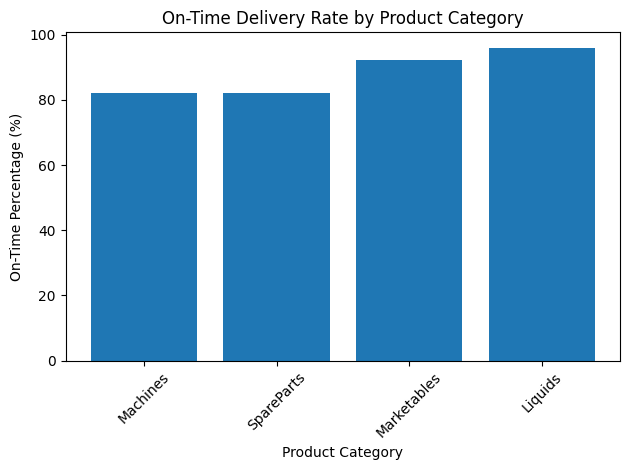

In [16]:
import matplotlib.pyplot as plt

# Calculate on-time percentage by category
service_rate = (
    shipments_with_category
    .groupby('prodCategory')['is_late']
    .mean()
)

on_time_pct = (1 - service_rate) * 100
on_time_pct = on_time_pct.sort_values()

# Plot
plt.figure()
plt.bar(on_time_pct.index, on_time_pct.values)

plt.title("On-Time Delivery Rate by Product Category")
plt.xlabel("Product Category")
plt.ylabel("On-Time Percentage (%)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

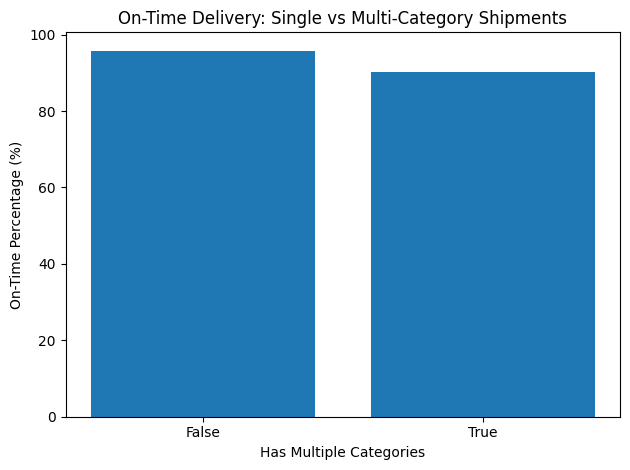

In [17]:
# Compare single vs multi-category shipments
complexity_service = (
    comprehensive_analysis
    .groupby('has_multiple_categories')['is_late']
    .mean()
)

on_time_complexity = (1 - complexity_service) * 100

plt.figure()
plt.bar(on_time_complexity.index.astype(str), on_time_complexity.values)

plt.title("On-Time Delivery: Single vs Multi-Category Shipments")
plt.xlabel("Has Multiple Categories")
plt.ylabel("On-Time Percentage (%)")

plt.tight_layout()
plt.show()

The first chart shows clear variation in on-time delivery rates across product categories, highlighting specific areas for improvement. The second chart confirms that shipments containing multiple product categories have lower on-time delivery rates than those with a single category, indicating increased operational complexity impacts performance. 

Focusing on underperforming product categories and simplifying shipment composition can help improve overall service levels.